In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [52]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import corner
import emcee
import h5py
import multiprocessing as multi
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import fmin_powell
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm_notebook
import warnings

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

In [184]:
class RunningChiEffPosterior(object):
    def __init__(self, chi_eff_samples, m1_samples, chi_eff_sel_samples, m1_sel_samples, sel_wts):
        self.chi_eff_samples = chi_eff_samples
        self.m1_samples = m1_samples
        self.chi_eff_sel_samples = chi_eff_sel_samples
        self.m1_sel_samples = m1_sel_samples
        self.log_sel_wts = log(sel_wts)
        
        self.m0 = 30
        
    def mu_sigma(self, m1, mu0, sigma0, alpha, beta):
        return mu0 + alpha*(m1/self.m0-1), sigma0*exp(beta*(m1/self.m0-1))
    
    def log_pdet(self, mu0, sigma0, alpha, beta):
        mus, sigmas = self.mu_sigma(self.m1_sel_samples, mu0, sigma0, alpha, beta)

        dist = ss.norm(loc=mus, scale=sigmas)
        logp_chieff = dist.logpdf(self.chi_eff_sel_samples) - log(dist.cdf(1) - dist.cdf(-1))
        
        return logp_chieff - self.log_sel_wts
    
    def neff_det(self, log_pdet):
        lpmax = np.max(log_pdet)
        
        return exp(logaddexp.reduce(log_pdet) - lpmax)
    
    def __call__(self, theta):
        mu0, sigma0, alpha, beta = theta
        
        # Check that -1 < mu < 1 for 1 < m < 100
        mulow, sigmalow = self.mu_sigma(1, mu0, sigma0, alpha, beta)
        muhigh, sigmahigh = self.mu_sigma(100, mu0, sigma0, alpha, beta)
        
        if mulow < -1 or mulow > 1:
            return np.NINF
        if muhigh < -1 or muhigh > 1:
            return np.NINF
        if sigmalow < 0 or sigmahigh < 0:
            return np.NINF
        if sigmalow > 2 or sigmahigh > 2:
            return np.NINF
        
        # Flat prior in mu0, sigma0, flat prior in alpha, beta
        lp = 0.0
        
        N = len(self.chi_eff_samples)
        logpd = self.log_pdet(mu0, sigma0, alpha, beta)
        neff = self.neff_det(logpd)
        
        if neff < 5*N:
            warnings.warn('too few samples in selection integral')
            return np.NINF
        
        log_mu = logaddexp.reduce(logpd) - log(len(logpd))
        
        lsel = -N*log_mu + (3*N + N*N)/(2*neff)

        ll = 0.0
        for chieffs, m1s in zip(self.chi_eff_samples, self.m1_samples):
            m, s = self.mu_sigma(m1s, mu0, sigma0, alpha, beta)
            dist = ss.norm(loc=m, scale=s)
            
            logp = dist.logpdf(chieffs) - log(dist.cdf(1) - dist.cdf(-1))
            ll += logaddexp.reduce(logp) - log(len(logp))
            
            
        result = ll + lp + lsel
        
        if np.isnan(result):
            print(theta)
            print(ll, lp, lsel)
            
        return result

In [185]:
def simulate_chi_eff_prior(size=1):
    mas = np.random.uniform(size=size)
    mbs = np.random.uniform(size=size)
    m1s = where(mas > mbs, mas, mbs)
    m2s = where(mas > mbs, mbs, mas)
    
    ct1s = np.random.uniform(low=-1, high=1, size=size)
    ct2s = np.random.uniform(low=-1, high=1, size=size)
    
    a1s = np.random.uniform(size=size)
    a2s = np.random.uniform(size=size)
    
    return (m1s*ct1s*a1s + m2s*ct2s*a2s)/(m1s+m2s)

In [186]:
chi_effs_prior = simulate_chi_eff_prior(10000)
approx_chi_eff_li_prior = ss.gaussian_kde(chi_effs_prior)

In [246]:
mu0_true = 0.05
sigma0_true = 0.1
alpha_true = -0.1
beta_true = -0.5

In [188]:
with h5py.File('design-selected.h5', 'r') as f:
    chi_effs_sel = array(f['chi_effs'])
    m1s_sel = array(f['m1s'])

In [189]:
N = 100
dist = ss.norm(loc=mu0_true + (m1s_sel/30 - 1)*alpha_true, scale=sigma0_true*exp(beta_true*(m1s_sel/30-1)))
wts = dist.pdf(chi_effs_sel)/(dist.cdf(1)-dist.cdf(-1))
wts /= np.sum(wts)
c = np.random.choice(len(wts), size=N, replace=False, p=wts)
chi_eff_true = chi_effs_sel[c]
m1_true = m1s_sel[c]

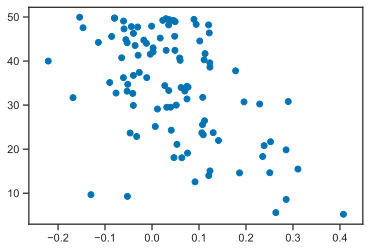

In [190]:
scatter(chi_eff_true, m1_true)

In [191]:
chi_eff_obs = chi_eff_true + 0.1*randn(len(chi_eff_true))
m1_obs = m1_true + 5*randn(len(m1_true))

In [192]:
Ns = 100
chi_eff_samples = [ceo + 0.1*randn(Ns) for ceo in chi_eff_obs]
m1_samples = [m1 + 5*randn(Ns) for m1 in m1_obs]

In [193]:
try:
    pool.close()
except:
    pass
pool = multi.Pool()

p0 = array([mu0_true, sigma0_true, alpha_true, beta_true])

Nw = 16
pts = p0 + 1e-3*randn(Nw, 4)
logpost = RunningChiEffPosterior(chi_eff_samples, m1_samples, chi_effs_sel, m1s_sel, 0.5*ones_like(m1s_sel))
sampler = emcee.EnsembleSampler(Nw, 4, logpost, pool=pool)

/Users/wfarr/anaconda3/envs/chieffregression/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: too few samples in selection integral
/Users/wfarr/anaconda3/envs/chieffregression/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: too few samples in selection integral
/Users/wfarr/anaconda3/envs/chieffregression/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: too few samples in selection integral
/Users/wfarr/anaconda3/envs/chieffregression/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: too few samples in selection integral


In [229]:
pts, lnprobs, rstate = sampler.run_mcmc(pts, 1024, progress=True)

/Users/wfarr/anaconda3/envs/chieffregression/lib/python3.7/site-packages/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|██████████| 1024/1024 [10:40<00:00,  1.60it/s]


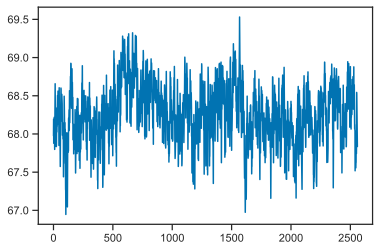

In [230]:
plot(mean(sampler.lnprobability, axis=0))

In [231]:
asampler = az.from_emcee(sampler, var_names=['mu0', 'sigma0', 'alpha', 'beta'])
az.ess(asampler)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu0      float64 601.0
    sigma0   float64 180.1
    alpha    float64 631.9
    beta     float64 213.7

In [232]:
az.plot_trace(asampler)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11fe215f8>,
      dtype=object)

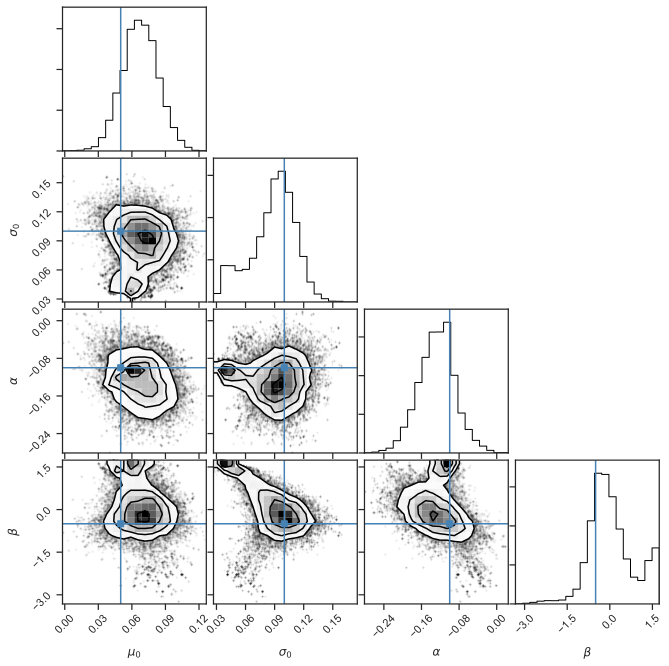

In [248]:
corner.corner(sampler.flatchain, truths=[mu0_true, sigma0_true, alpha_true, beta_true],
              labels=[r'$\mu_0$', r'$\sigma_0$', r'$\alpha$', r'$\beta$']);

In [235]:
az.to_netcdf(asampler, "pop-samples-running-future.nc")

'pop-samples-running-future.nc'

In [236]:
m1s = logspace(log10(5), log10(50), 100)
chis = linspace(-1, 1, 100)
M1S, CHIS = meshgrid(m1s, chis, indexing='ij')

In [238]:
asampler.posterior

<xarray.Dataset>
Dimensions:  (chain: 16, draw: 2560)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 2553 2554 2555 2556 2557 2558 2559
Data variables:
    mu0      (chain, draw) float64 0.08663 0.08663 0.08663 ... 0.06882 0.06913
    sigma0   (chain, draw) float64 0.09127 0.09127 0.09127 ... 0.1175 0.1174
    alpha    (chain, draw) float64 -0.1186 -0.1186 -0.1186 ... -0.1908 -0.1963
    beta     (chain, draw) float64 -0.7212 -0.7212 -0.7212 ... 0.1457 0.1649
Attributes:
    created_at:                 2019-10-23T04:55:47.307940
    inference_library:          emcee
    inference_library_version:  3.0.0

In [242]:
Ndraw = 1000
PCHIS = zeros_like(CHIS)
for i in tqdm_notebook(range(Ndraw)):
    j = randint(asampler.posterior.chain[-1])
    k = randint(asampler.posterior.draw[-1])
    
    mu0 = asampler.posterior.mu0.values[j,k]
    sigma0 = asampler.posterior.sigma0.values[j,k]
    alpha = asampler.posterior.alpha.values[j,k]
    beta = asampler.posterior.beta.values[j,k]
    
    m, s = logpost.mu_sigma(M1S, mu0, sigma0, alpha, beta)
    dist = ss.norm(loc=m, scale=s)
    
    PCHIS += dist.pdf(CHIS)/(dist.cdf(1)-dist.cdf(-1))
PCHIS /= Ndraw

Text(0, 0.5, '$m_1$ ($M_\\odot$)')

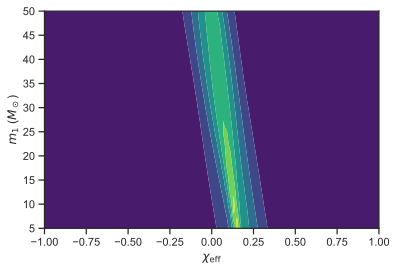

In [250]:
contourf(CHIS, M1S, PCHIS, cmap='viridis', vmin=0)
xlabel(r'$\chi_\mathrm{eff}$')
ylabel(r'$m_1$ ($M_\odot$)')

In [251]:
m, s = logpost.mu_sigma(M1S, mu0_true, sigma0_true, alpha_true, beta_true)
dist = ss.norm(loc=m, scale=s)
PCHIS_TRUE = dist.pdf(CHIS)/(dist.cdf(1)-dist.cdf(-1))

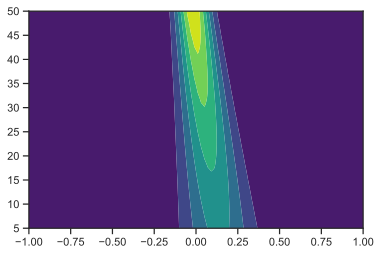

In [252]:
contourf(CHIS, M1S, PCHIS_TRUE, cmap='viridis', vmin=0)